In [1]:
# Utility
import re
import numpy as np
import pandas as pd

# OS I/O
import requests
import inspect
import sys
import os

# Image Processing
import cv2

# Custom Utils
abspathdir = os.path.abspath(inspect.getfile(inspect.currentframe()))
currentdir = os.path.dirname(abspathdir)
parentdir  = os.path.dirname(currentdir)
sys.path.insert(0, parentdir) 

from Utils._fe_utils import DatasetManager, get_id

In [ ]:
relpath  = parentdir + '/Data/'
videos_filename = 'refined_2M_all_video_url.csv'
audios_filename = 'all_music_mp3_url.csv'

audio_urls = []
music_ids = []
all_audio_data = pd.read_csv(relpath + audios_filename, header=None)
for url in all_audio_data[0]:
    audio_urls.append(url)
    ri = url.rindex('/') + 1
    of, fex = os.path.splitext(url[ri:])
    music_ids.append(of)

all_video_data = pd.read_csv(relpath + videos_filename, header=None)
data_mask = all_video_data[0].str.contains("c02")

video_urls = []
for idx, url in enumerate(all_video_data[data_mask][0]):
    video_urls.append(url)

video_urls_by_music_id = []
for id_ in music_ids:
    trim = list(filter(lambda k: id_ in k, video_urls))
    video_urls_by_music_id.append(trim)

print(len(video_urls))

In [2]:
temp_dir = currentdir + '/tmpdata'
db_dir   = currentdir + '/tmpdata'
dbmanager = DatasetManager(temp_dir, db_dir)

In [3]:
import joblib
dbname = "/mgdb.pkl"
db = joblib.load(db_dir + dbname)
#print(db["Video"].keys())
print(len(db["Video"].keys()))
print(len(db["Audio"].keys()))

#dd = get_id("gJB_sGR_c01_d07_d08_d09_mJB0_ch01")

#print(db["Video"][dd])

#df = pd.DataFrame(db)
#print(df)

3120
60


In [ ]:
print(db["Audio"])

In [ ]:
audio_download_params = {
    "samplerate": 22050,
    "start_t": 0, "end_t": 4
}

dbmanager.download_and_dump_audio(audio_urls, **audio_download_params)

In [ ]:
video_download_params = {
    "color": False,
    "sizex": 320, "sizey": 240,
    "start_t": 0, "end_t": 4
}

dbmanager.download_and_dump_videos(video_urls, **video_download_params)

In [4]:
'''
from Utils._fe_utils import motiongram, extract_subclip, convert_to_avi
#test_url = './boomwhackers.mp4'
#boom_path = extract_subclip(test_url, 10, 25, './boomwhackers_15sec.mp4')
#boom_path = convert_to_avi(boom_path)
boom_path = './boomwhackers_15sec.avi'
mgx, mgy = motiongram(boom_path,
    size = (640, 480),
    color = True
)
print(mgx.shape, mgy.shape)
'''
li = list(db["Video"].keys())
print(li[-1:-10:-1])

['cb6b664e21cf89f8af8059cd00ca4fa276e8834d', 'd5d589ea26f964a74e9d570aa10a8fef6a33d66a', '6bf3ca59e5f41f4d08d952b9860716b277fd997d', '240439e0016a4880ac63727997b89ac2cb949edf', '3c4d2d43ba52b92a8f6d014773aaab019314bc0d', 'd76ad2149a4262d5a16883ab6bc30c4ca1b87313', '65e8f5d5530049870e85e909d8b7cca55680286b', '74ae47594a434a9aa73673e1cdb8fc8a6603ea34', 'c72060d58a3e575d629616eaf9c5003e09a8843c']


(240, 320, 3) (240, 240, 3)


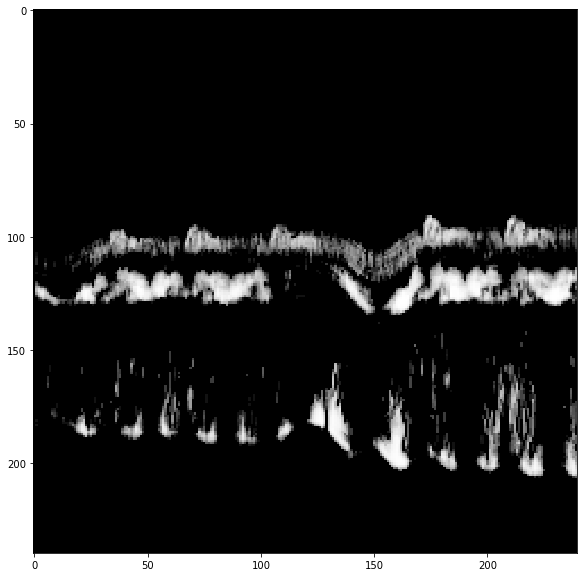

In [7]:

kv = li[1800]
#print(db["Video"][kv])
#db = runner.get_db()[k]
mgx = db["Video"][kv]["MotiongramX"]
mgy = db["Video"][kv]["MotiongramY"]

print(mgx.shape, mgy.shape)

import matplotlib.pyplot as plt
plt.figure(figsize=(10, 10))
plt.imshow(mgy)
plt.show()


In [ ]:
k = get_id(db["Video"][kv]['MetaInfo']['MusicID'])#list(db["Audio"].keys())[2]
print(k)

entry = db["Audio"][k]
print(entry)
print(list(entry.keys()))

import librosa
import librosa.display
import matplotlib.pyplot as plt



fig, ax = plt.subplots(nrows=3, ncols=1, sharex=True, figsize=(10, 15))

y = entry["RawAudio"]
sr = entry["SampleRate"]

librosa.display.waveshow(y, sr=sr, ax=ax[0])

D = librosa.amplitude_to_db(np.abs(librosa.stft(y)), ref=np.max)
img = librosa.display.specshow(D, y_axis='linear', x_axis='time',
                               sr=sr, ax=ax[1])
ax[1].set(title='Linear-frequency power spectrogram')
ax[1].label_outer()

hop_length = 1024
D = librosa.amplitude_to_db(np.abs(librosa.stft(y, hop_length=hop_length)),
                            ref=np.max)
librosa.display.specshow(D, y_axis='log', sr=sr, hop_length=hop_length,
                         x_axis='time', ax=ax[2])
ax[2].set(title='Log-frequency power spectrogram')
ax[2].label_outer()
fig.colorbar(img, ax=ax, format="%+2.f dB")


import IPython.display as ipd
ipd.Audio(entry["RawAudio"], rate=entry["SampleRate"])